# Exploratory Data Analysis on Russian Propaganda Telegram Channels
## Author: Artem Korniienko

In [42]:
import re
import string
import random
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
from collections import Counter
from tqdm import tqdm
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

## Getting merged dataset

In [43]:
warnings.filterwarnings('ignore')
merged_channels = "../merged_channels"
output_file = f"{merged_channels}.csv"

In [3]:
df = pd.read_csv(output_file, low_memory=False)

In [4]:
df.shape

(8108693, 14)

## What is a date range of posts for our dataset?

In [44]:
min(df["date"]), max(df["date"])

(Timestamp('2015-09-22 11:53:32+0000', tz='UTC'),
 Timestamp('2022-12-26 10:59:50+0000', tz='UTC'))

## Let's observe types of media in channels and their respective counts.

In [45]:
df.groupby(["type"])["type"].count()

type
photo      3374347
sticker       9879
text       3407150
video      1309641
voice         7676
Name: type, dtype: int64

## Let's inspect final structure of dataframe

In [23]:
df.head(10)

,Unnamed: 0,id,date,views,reactions,to_id,fwd_from,message,type,duration,channel_name,frw_from_title,frw_from_name,msg_entity,day_of_week
0,0,12602.0,2022-12-19 13:05:23+00:00,3645.0,MessageReactions(results=[ReactionCount(reacti...,PeerChannel(channel_id=1261603870),NaN,🇵🇰🇦🇫 Исламабад сделал ставку на афганских тали...,photo,NaN,Abbasdjuma,NaN,NaN,NaN,0
1,1,12601.0,2022-12-19 09:52:21+00:00,5831.0,MessageReactions(results=[ReactionCount(reacti...,PeerChannel(channel_id=1261603870),NaN,"🕯️ 6 лет назад, 19 декабря 2016 года, в резуль...",photo,NaN,Abbasdjuma,NaN,NaN,NaN,0
2,2,12600.0,2022-12-19 09:18:53+00:00,3944.0,MessageReactions(results=[ReactionCount(reacti...,PeerChannel(channel_id=1261603870),NaN,🇮🇷🇷🇺 Глава МИД Ирана Хосейн Амир Абдоллахиян с...,photo,NaN,Abbasdjuma,NaN,NaN,NaN,0
3,3,12599.0,2022-12-19 08:32:39+00:00,2970.0,MessageReactions(results=[ReactionCount(reacti...,PeerChannel(channel_id=1261603870),"MessageFwdHeader(date=datetime.datetime(2022, ...",Наши Друзья открыли \nсбор для одного из Доне...,photo,NaN,Abbasdjuma,NaN,NaN,NaN,0
4,4,12598.0,2022-12-18 21:41:25+00:00,4993.0,MessageReactions(results=[ReactionCount(reacti...,PeerChannel(channel_id=1261603870),NaN,"🇷🇺 Сегодня, 19 декабря в России празднуют День...",photo,NaN,Abbasdjuma,NaN,NaN,NaN,6
5,5,12597.0,2022-12-18 13:39:35+00:00,5713.0,MessageReactions(results=[ReactionCount(reacti...,PeerChannel(channel_id=1261603870),NaN,📰📰📰❤️\n\n#Дайджест_СМИ \n\n📰 ABC: Папа римский...,photo,NaN,Abbasdjuma,NaN,NaN,NaN,6
6,6,12596.0,2022-12-18 08:38:12+00:00,6186.0,MessageReactions(results=[ReactionCount(reacti...,PeerChannel(channel_id=1261603870),NaN,🇷🇺🇷🇸🇬🇷 Российский посол в Сербии Александр Боц...,photo,NaN,Abbasdjuma,NaN,NaN,NaN,6
7,7,12595.0,2022-12-17 14:37:20+00:00,6181.0,MessageReactions(results=[ReactionCount(reacti...,PeerChannel(channel_id=1261603870),"MessageFwdHeader(date=datetime.datetime(2022, ...",🇮🇷🇷🇺 Директор Центрального разведывательного у...,photo,NaN,Abbasdjuma,NaN,NaN,NaN,5
8,8,12594.0,2022-12-17 08:31:08+00:00,80764.0,MessageReactions(results=[ReactionCount(reacti...,PeerChannel(channel_id=1261603870),NaN,🇷🇺🇺🇦 ⚡️⚡️⚡️⚡️⚡️\n\nНедавно я писал об освобожд...,video,103.0,Abbasdjuma,NaN,NaN,NaN,5
9,9,12593.0,2022-12-17 08:00:35+00:00,6889.0,MessageReactions(results=[ReactionCount(reacti...,PeerChannel(channel_id=1261603870),"MessageFwdHeader(date=datetime.datetime(2022, ...","🇮🇳🇪🇺 В Индии уверены, что Запад не откажется о...",photo,NaN,Abbasdjuma,NaN,NaN,NaN,5


# Observing dataset

## Question: How many times Putin was mentioned overall?

In [47]:
putin_pattern = re.compile(r'\b[пП][уУ][тТ][иИ][нН]\b')
altered_df = df
altered_df["pu_mention_count"] = df["message"].apply(lambda x: len(re.findall(putin_pattern, str(x))))
total_mentions_pu = altered_df["pu_mention_count"].sum()
print(total_mentions_pu)

335699


## Question: How many times was Zelensky mentioned overall?

In [48]:
zelensky_pattern = re.compile(r'\b[зЗ][еЕ][лЛ][еЕ][нН][сС][кК][иИ][йЙ]\b')
altered_df["ze_mention_count"] = df["message"].apply(lambda x: len(re.findall(zelensky_pattern, str(x))))
total_mentions_ze = altered_df["ze_mention_count"].sum()
print(total_mentions_ze)

79235


## Question: What is their mention rate per day?

In [49]:
altered_df['date'] = pd.to_datetime(altered_df['date'])
altered_df = altered_df[altered_df["date"].dt.year >= 2018]

daily_mentions_pu = altered_df.groupby(altered_df["date"].dt.date)["pu_mention_count"].sum()

daily_mentions_ze = altered_df.groupby(altered_df["date"].dt.date)["ze_mention_count"].sum()

max_pu_date = daily_mentions_pu.idxmax()
max_pu_mentions = daily_mentions_pu.max()

max_ze_date = daily_mentions_ze.idxmax()
max_ze_mentions = daily_mentions_ze.max()

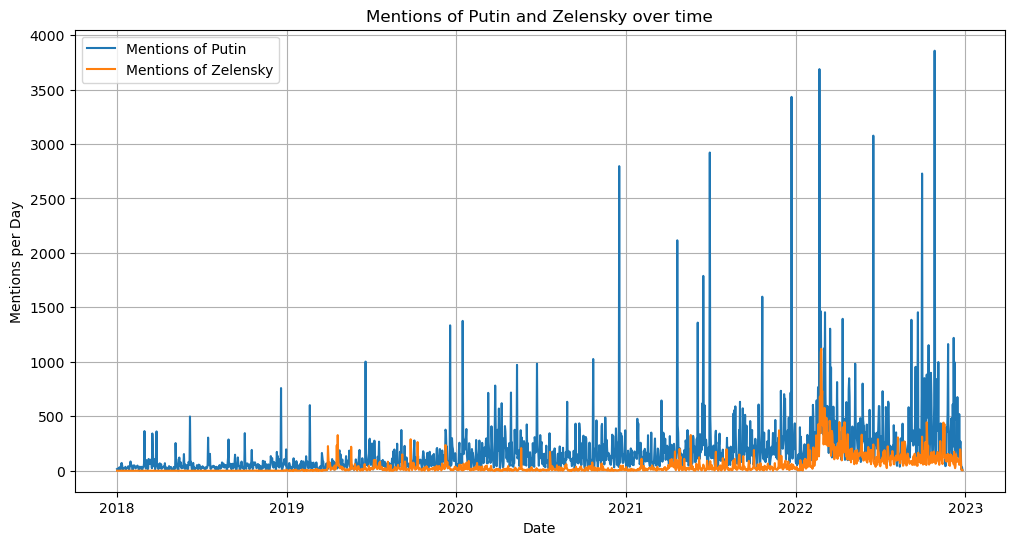

Most Putin Mentions: 3857 on 2022-10-27
Most Zelensky Mentions: 1120 on 2022-02-25


In [55]:
peak_threshold = 50

plt.figure(figsize=(12, 6))
plt.plot(daily_mentions_pu.index, daily_mentions_pu.values, label="Mentions of Putin")
plt.plot(daily_mentions_ze.index, daily_mentions_ze.values, label="Mentions of Zelensky")
plt.xlabel("Date")
plt.ylabel("Mentions per Day")
plt.title("Mentions of Putin and Zelensky over time")
plt.legend()
plt.grid(True)
plt.savefig("graphs/ZvsPu.png")
plt.show()

print(f'Most Putin Mentions: {max_pu_mentions} on {max_pu_date}')
print(f'Most Zelensky Mentions: {max_ze_mentions} on {max_ze_date}')


## Question: What are the main words that are commonly used together with Putin?

In [56]:
nltk.download("stopwords")
nltk.download("punkt")

stop_words = set(stopwords.words("russian"))
co_occurred_words = []

total_messages = len(df)
chunk_size = 100 


def process_chunk(chunk):
    chunk_co_occurred_words = []
    for index, row in chunk.iterrows():
        message_date = row['date']
        if message_date >= pd.to_datetime('2022-02-24', utc=True):
            message = row['message']
            words = nltk.word_tokenize(str(message))
            words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
            if 'путин' in words:
                chunk_co_occurred_words.extend([word for word in words if word != 'путин'])
    return chunk_co_occurred_words


for chunk_start in range(0, total_messages, chunk_size):
    chunk_end = min(chunk_start + chunk_size, total_messages)
    chunk = df.iloc[chunk_start:chunk_end]
    chunk_co_occurred_words = process_chunk(chunk)
    co_occurred_words.extend(chunk_co_occurred_words)

    progress = (chunk_end) / total_messages * 100
    print(f"Processed {progress:.2f}% of messages", end="\r")

word_counts = Counter(co_occurred_words)
most_common_co_occurred = word_counts.most_common(50)

for word, count in most_common_co_occurred:
    print(f"Word: {word}, Co-occurrence Count: {count}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yg_ya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yg_ya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Word: это, Co-occurrence Count: 41203
Word: россии, Co-occurrence Count: 40559
Word: владимир, Co-occurrence Count: 26494
Word: рф, Co-occurrence Count: 18661
Word: президент, Co-occurrence Count: 18060
Word: украине, Co-occurrence Count: 15725
Word: россия, Co-occurrence Count: 15472
Word: заявил, Co-occurrence Count: 15217
Word: украины, Co-occurrence Count: 13546
Word: также, Co-occurrence Count: 11520
Word: сша, Co-occurrence Count: 11276
Word: которые, Co-occurrence Count: 11171
Word: путина, Co-occurrence Count: 10067
Word: года, Co-occurrence Count: 9242
Word: страны, Co-occurrence Count: 9114
Word: время, Co-occurrence Count: 8530
Word: будут, Co-occurrence Count: 8401
Word: президента, Co-occurrence Count: 8372
Word: сегодня, Co-occurrence Count: 7780
Word: подписаться, Co-occurrence Count: 7750
Word: против, Co-occurrence Count: 7105
Word: который, Co-occurrence Count: 6742
Word: сказал, Co-occurrence Count: 6467
Word: лет, Co-occurrence Count: 6116
Word: очень, Co-occurrence

## What about Zelensky?

In [57]:
stop_words = set(stopwords.words("russian"))
co_occurred_words = []

total_messages = len(df)
chunk_size = 100


def process_chunk(chunk):
    chunk_co_occurred_words = []
    for index, row in chunk.iterrows():
        message_date = row['date']
        if message_date >= pd.to_datetime('2022-02-24', utc=True):
            message = row['message']
            words = nltk.word_tokenize(str(message))
            words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
            if 'зеленский' in words:
                chunk_co_occurred_words.extend([word for word in words if word != 'зеленский'])
    return chunk_co_occurred_words


for chunk_start in range(0, total_messages, chunk_size):
    chunk_end = min(chunk_start + chunk_size, total_messages)
    chunk = df.iloc[chunk_start:chunk_end]
    chunk_co_occurred_words = process_chunk(chunk)
    co_occurred_words.extend(chunk_co_occurred_words)

    progress = (chunk_end) / total_messages * 100
    print(f"Processed {progress:.2f}% of messages", end="\r")

word_counts = Counter(co_occurred_words)
most_common_co_occurred = word_counts.most_common(50)

for word, count in most_common_co_occurred:
    print(f"Word: {word}, Co-occurrence Count: {count}")

Word: украины, Co-occurrence Count: 23453
Word: это, Co-occurrence Count: 23156
Word: россии, Co-occurrence Count: 12731
Word: украине, Co-occurrence Count: 11314
Word: заявил, Co-occurrence Count: 10059
Word: владимир, Co-occurrence Count: 9706
Word: президент, Co-occurrence Count: 9269
Word: зеленского, Co-occurrence Count: 7574
Word: сша, Co-occurrence Count: 7067
Word: украина, Co-occurrence Count: 6840
Word: рф, Co-occurrence Count: 5908
Word: всу, Co-occurrence Count: 5831
Word: которые, Co-occurrence Count: 5651
Word: также, Co-occurrence Count: 5278
Word: россия, Co-occurrence Count: 5202
Word: нато, Co-occurrence Count: 4914
Word: время, Co-occurrence Count: 4734
Word: страны, Co-occurrence Count: 4609
Word: президента, Co-occurrence Count: 4448
Word: против, Co-occurrence Count: 4265
Word: россией, Co-occurrence Count: 4135
Word: украину, Co-occurrence Count: 3960
Word: который, Co-occurrence Count: 3913
Word: украинских, Co-occurrence Count: 3886
Word: киев, Co-occurrence Co

## Question: What is the distribution of the word "hohol"

In [58]:
df['date'] = pd.to_datetime(df['date'], utc=True)

messages_containing_hoh = df[df['message'].str.contains("хох", case=False, na=False)]

message_distribution = messages_containing_hoh.resample('W', on='date')['id'].count()

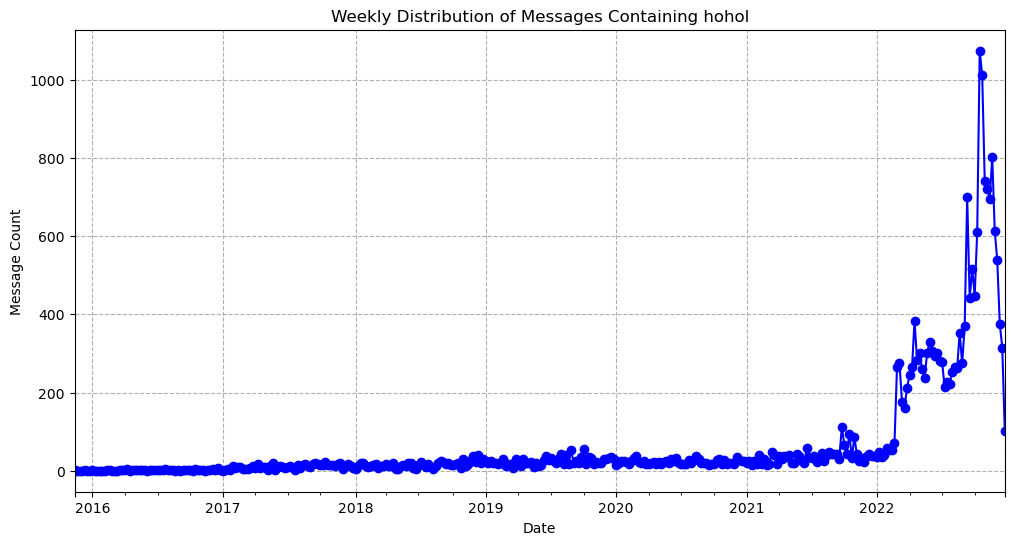

In [59]:
plt.figure(figsize=(12, 6))
message_distribution.plot(kind='line', marker='o', linestyle='-', color='b')
plt.title('Weekly Distribution of Messages Containing hohol')
plt.xlabel('Date')
plt.ylabel('Message Count')
plt.grid(True, linestyle='--')
plt.savefig("graphs/gXox.png")
plt.show()

## Qustion: What is average duration of the video file?

In [60]:
media_posts = df[df['type'] == 'video']

average_duration = media_posts['duration'].mean()

print(f"The average duration of media posts across all channels is {average_duration:.2f} seconds.")

The average duration of media posts across all channels is 69.09 seconds.


## Question: How does the number of posts vary by month or year for each channel?(shown top 10)

In [61]:
df['date'] = pd.to_datetime(df['date'], utc=True)

df['post_month'] = df['date'].dt.month
df['post_year'] = df['date'].dt.year

posts_by_month = df.groupby(['channel_name', 'post_year', 'post_month'])['id'].count()

posts_by_month = posts_by_month.reset_index()

top_10_channels = posts_by_month.groupby(['channel_name'])['id'].sum().nlargest(10).index

top_10_data = posts_by_month[posts_by_month['channel_name'].isin(top_10_channels)]

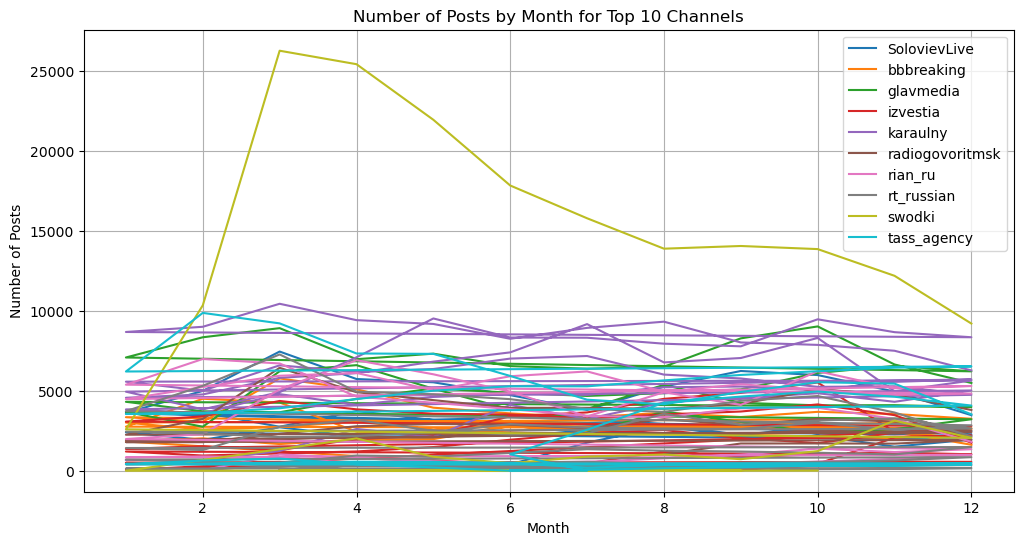

In [62]:
plt.figure(figsize=(12, 6))
for channel_name, channel_data in top_10_data.groupby('channel_name'):
    plt.plot(channel_data['post_month'], channel_data['id'], label=channel_name)

plt.title('Number of Posts by Month for Top 10 Channels')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend()
plt.grid(True)
plt.savefig("graphs/Posts10Channels.png")
plt.show()

## Question: Which channels have the most active posting schedule?

In [63]:
df['date'] = pd.to_datetime(df['date'], utc=True)

posts_per_day = df.groupby(['channel_name', df['date'].dt.date])['id'].count()

average_posts_per_day = posts_per_day.groupby('channel_name').mean()

most_active_channels = average_posts_per_day.nlargest(5) 

print("Channels with the Most Active Posting Schedules:")
print(most_active_channels)

Channels with the Most Active Posting Schedules:
channel_name
swodki       307.025078
karaulny     199.581577
glavmedia    171.784591
chtddd       136.967672
ssigny       116.461347
Name: id, dtype: float64


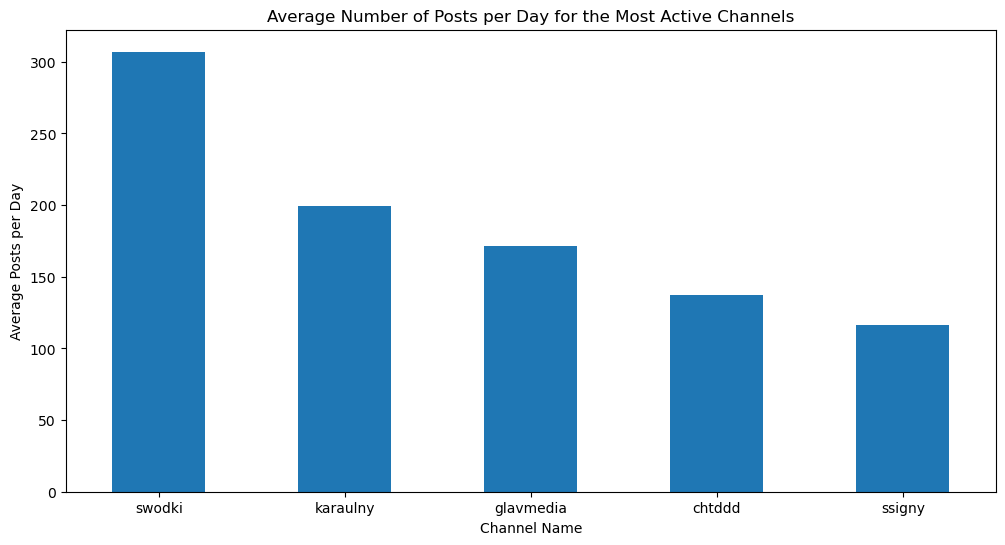

In [64]:
plt.figure(figsize=(12, 6))
most_active_channels.plot(kind='bar', rot=0)
plt.title('Average Number of Posts per Day for the Most Active Channels')
plt.xlabel('Channel Name')
plt.ylabel('Average Posts per Day')
plt.savefig("graphs/PostsForActiveChannels.png")
plt.show()

## Question: What is most common words patterns(in one-month time period).

### Finding month with the most messages.

In [65]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')
month_post_counts = df['month'].value_counts()

most_posts_month = month_post_counts.idxmax()

print(f"The month with the most posts is: {most_posts_month}")

filtered_df = df[df['month'] == most_posts_month]

The month with the most posts is: 2022-03


In [66]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

def extract_ngrams(text, n):
    if isinstance(text, str):
        text = preprocess_text(text)
        tokens = nltk.word_tokenize(text)
        n_grams = [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
        return [' '.join(gram) for gram in n_grams]
    else:
        return []

def process_ngrams(chunk_df, n, pbar):
    ngram_counts = Counter()
    for text in chunk_df['message']:
        ngrams = extract_ngrams(text, n)
        ngram_counts.update(ngrams)
    pbar.update(1)
    return ngram_counts

ngram_lengths = [2, 3]
chunk_size = 100

start_time = '2022-03-01'
end_time = '2022-03-31'

filtered_df = df[(df['date'] >= start_time) & (df['date'] < end_time)]
num_chunks = len(filtered_df)

ngram_counts = {n: Counter() for n in ngram_lengths}

for ngram_length in ngram_lengths:
    pbar = tqdm(total=num_chunks, desc=f"Processing {ngram_length}-grams")
    for chunk_start in range(0, len(filtered_df), chunk_size):
        chunk_df = filtered_df.iloc[chunk_start:chunk_start + chunk_size]
        ngram_counts[ngram_length] += process_ngrams(chunk_df, ngram_length, pbar)
    pbar.close()

top_n = 50

top_ngrams_2 = ngram_counts[2].most_common(top_n)
top_ngrams_3 = ngram_counts[3].most_common(top_n)

Processing 2-grams:   1%|          | 2791/397576 [04:44<16:21:17,  6.71it/s]

KeyboardInterrupt: 

In [ ]:
top_ngrams_2

In [ ]:
top_ngrams_3

In [ ]:
top_ngrams_to_plot = top_ngrams_2[len(top_ngrams_2)-30:len(top_ngrams_2)]
plt.figure(figsize=(10, 6))
ngrams, counts = zip(*top_ngrams_to_plot)

plt.barh(ngrams, counts)
plt.title(f'Top {2}-grams in All Text')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig("graphs/Top2Grams.png")
plt.show()

In [ ]:
top_ngrams_to_plot = top_ngrams_3[len(top_ngrams_3)-50:len(top_ngrams_3)-20]
plt.figure(figsize=(10, 6))
ngrams, counts = zip(*top_ngrams_to_plot)

plt.barh(ngrams, counts)
plt.title(f'Top {3}-grams in All Text')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig("graphs/Top3Grams.png")
plt.show()

## Question: What is the most common word  used in text posts for certain amount of channels?

In [67]:
start_date = pd.to_datetime('2022-02-24', utc=True)
end_date = pd.to_datetime('2022-12-31', utc=True)

random_channels = random.sample(df['channel_name'].unique().tolist(), 50)

text_posts = df[(df['type'] == 'text') & (df['date'] >= start_date) & (df['date'] <= end_date) & (df['channel_name'].isin(random_channels))]

text_posts['words'] = text_posts['message'].str.split()
text_posts = text_posts.explode('words')
text_posts = text_posts[text_posts['words'].str.len() > 3]

most_common_words = text_posts.groupby(['channel_name', 'words']).size().reset_index(name='count')
most_common_words = most_common_words.groupby('channel_name').apply(lambda x: x.nlargest(1, 'count')).reset_index(drop=True)

print(most_common_words)

             channel_name                   words  count
0            Ateobreaking                  России   2317
1         BattleSailor_13                 сегодня    465
2               ChDambiev                   будет    102
3      HouseOfCardsRussia                  России   1598
4           InsightPeople                 Insight     46
5           MedvedevVesti                  только    856
6        Medvedeva_Olesya                   будет     48
7       NoodleRemoverPlus                  только     80
8          RIAKremlinpool                   Путин    557
9           TanyaChuprova                    меня    163
10                achexd2                говорит:    204
11             antiskrepa                   будет    719
12           berdovaalena                   чтобы     61
13               ctrs2018               @ctrs2018   2244
14           golosmordora                   будет   1003
15             ikakprosto                    меня     19
16           imnotbozhena      

## Question: Which channels have the highest average views and reactions per post?

In [68]:
channel_stats = df.groupby('channel_name')
average_views = channel_stats['views'].mean()
average_stats = pd.DataFrame({'Average Views': average_views})
sorted_stats = average_stats.sort_values(by=['Average Views'], ascending=False)
top_10_channels = sorted_stats.head(10)

<Figure size 1200x600 with 0 Axes>

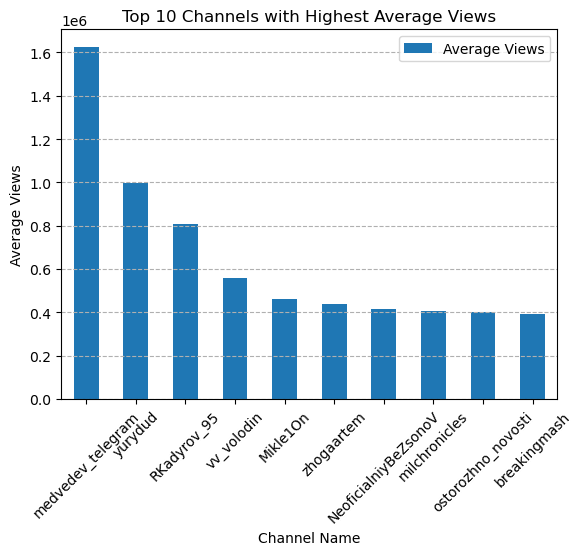

In [69]:
plt.figure(figsize=(12, 6))
top_10_channels.plot(kind='bar', rot=45)
plt.title('Top 10 Channels with Highest Average Views')
plt.xlabel('Channel Name')
plt.ylabel('Average Views')
plt.grid(axis='y', linestyle='--')
plt.savefig("graphs/Highest reaction channels.png")
plt.show()

## Question: Which channels have the highest and lowest average post views?

In [70]:
average_post_views = df.groupby('channel_name')['views'].mean()
highest_average_views = average_post_views.idxmax()
lowest_average_views = average_post_views.idxmin()

highest_average_views_value = average_post_views.max()
lowest_average_views_value = average_post_views.min()

highest_lowest_average_views = pd.DataFrame({
    'Channel': [highest_average_views, lowest_average_views],
    'Average Post Views': [highest_average_views_value, lowest_average_views_value]
})

<Figure size 1000x500 with 0 Axes>

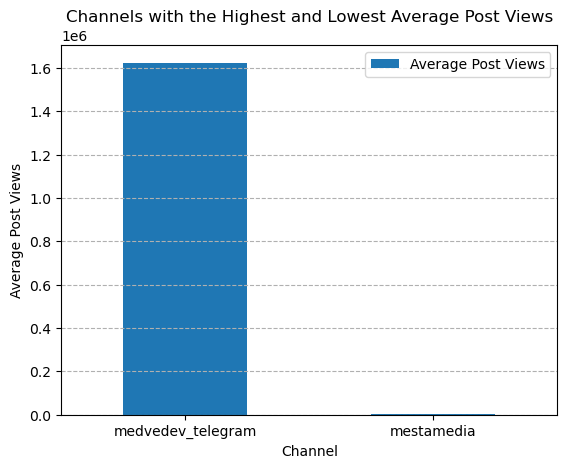

In [71]:
plt.figure(figsize=(10, 5))
highest_lowest_average_views.plot(x='Channel', y='Average Post Views', kind='bar', rot=0)
plt.title('Channels with the Highest and Lowest Average Post Views')
plt.xlabel('Channel')
plt.ylabel('Average Post Views')
plt.grid(axis='y', linestyle='--')
plt.savefig("graphs/HighestLowestPostViews.png")
plt.show()

## Question: Which channel has the most amount of posts?

In [72]:
channel_post_counts = df['channel_name'].value_counts()

most_posts_channel = channel_post_counts.idxmax()
most_posts_count = channel_post_counts.max()

print(f"The channel with the most posts is '{most_posts_channel}' with {most_posts_count} posts.")

The channel with the most posts is 'karaulny' with 435487 posts.


## Question: Which channels have the most rapid growth in post count over a specific period?(before and right after the invasion)

In [73]:
df['date'] = pd.to_datetime(df['date'], utc=True)

start_date = pd.to_datetime('2022-01-01', utc=True)
end_date = pd.to_datetime('2022-03-01', utc=True)

filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

post_count_growth = filtered_df.groupby(['channel_name', filtered_df['date'].dt.date])['to_id'].count().reset_index()
post_count_growth = post_count_growth.pivot(index='channel_name', columns='date', values='to_id')

growth_rate = post_count_growth.diff(axis=1).mean(axis=1)
most_rapid_growth_channels = growth_rate.nlargest(10)

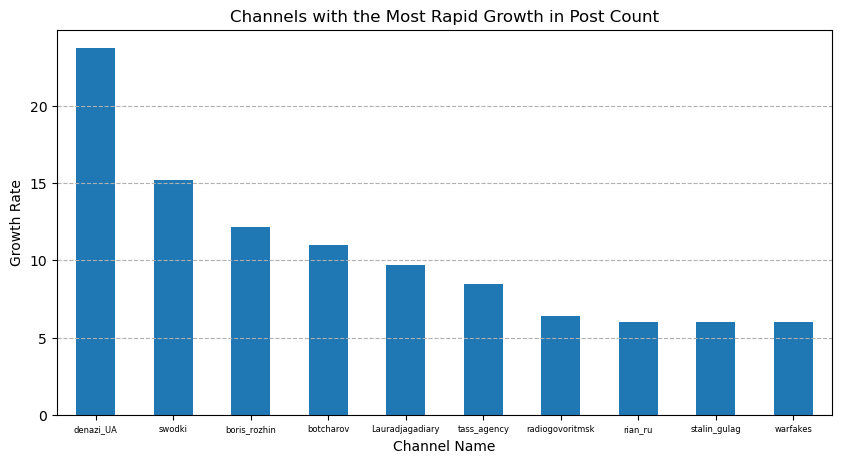

In [74]:
plt.figure(figsize=(10, 5))
most_rapid_growth_channels.plot(kind='bar', rot=0)
plt.title('Channels with the Most Rapid Growth in Post Count')
plt.xlabel('Channel Name')
plt.ylabel('Growth Rate')
plt.grid(axis='y', linestyle='--')
plt.xticks(fontsize = 6)
plt.savefig("graphs/MostRapidGrowthChannels.png")
plt.show()

##  Question: What is the distribution of post types (text or media) across all channels and each channel specifically?

In [75]:
media_posts = df[df['type'].isin(['photo', 'video', 'audio'])]

post_type_distribution = df['type'].value_counts()

channel_post_type_distribution = df.groupby('channel_name')['type'].value_counts().unstack(fill_value=0)

In [76]:
post_type_distribution.head(10)
channel_post_type_distribution.head(10)

type,photo,sticker,text,video,voice
channel_name,,,,,
ASGasparyan,12430,1,14500,4116,4
Abbasdjuma,7760,8,3308,925,1
Alekhin_Telega,1308,1,4219,315,1
Ateobreaking,12560,22,55711,7338,3
Baronova,9021,29,11199,1226,15
BattleSailor_13,2065,5,1171,908,1
ChDambiev,13777,0,385,6435,0
DmitriySteshin,2961,0,2325,1019,3
Doninside,5924,2,9042,2546,1


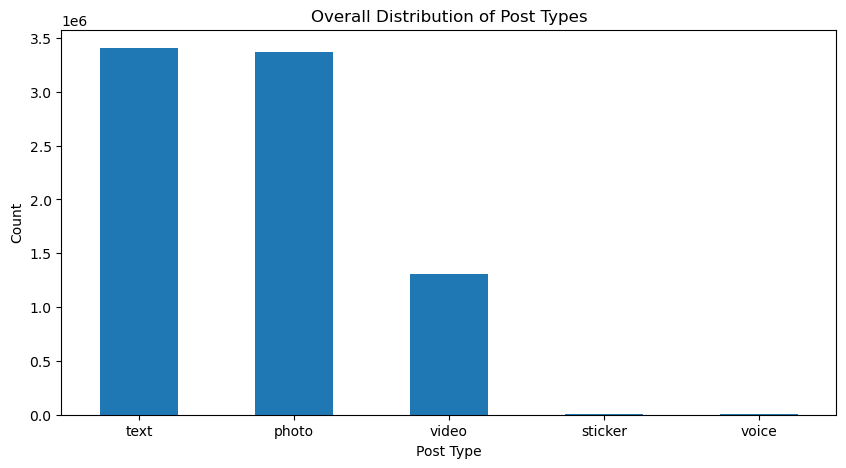

In [77]:
plt.figure(figsize=(10, 5))

post_type_distribution.plot(kind='bar', rot=0)
plt.title('Overall Distribution of Post Types')
plt.xlabel('Post Type')
plt.ylabel('Count')
plt.savefig("graphs/OverallDistributionOfPostTypes.png")

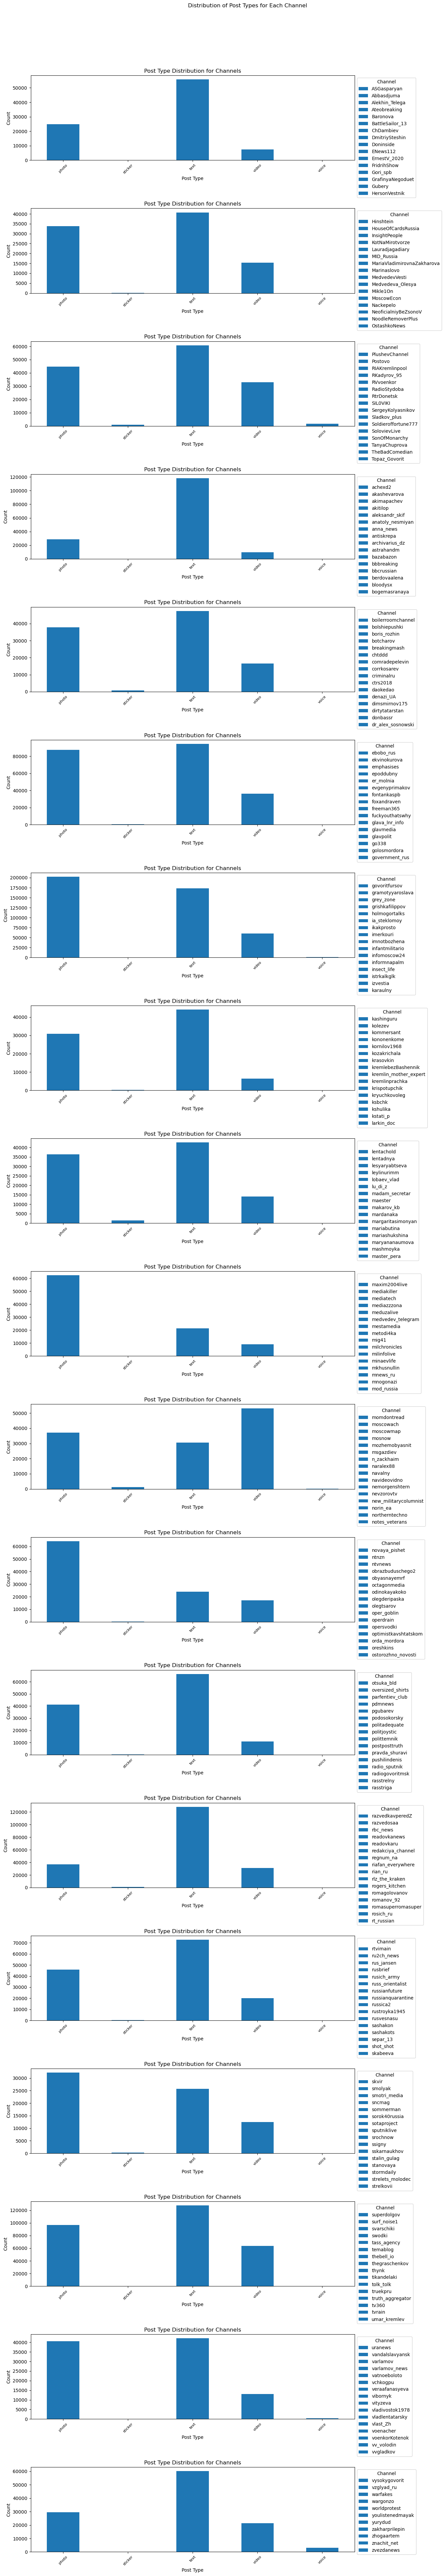

In [78]:
channels = channel_post_type_distribution.index

num_channels_per_graph = 16  
num_graphs = (len(channels) + num_channels_per_graph - 1) // num_channels_per_graph

fig, axes = plt.subplots(num_graphs, 1, figsize=(15, 4 * num_graphs))
fig.suptitle('Distribution of Post Types for Each Channel', y=1.02)

for idx, channel in enumerate(channels):
    graph_idx = idx // num_channels_per_graph
    ax = axes[graph_idx] if num_graphs > 1 else axes

    channel_post_type_distribution.loc[channel].plot(kind='bar', stacked=True, ax=ax, label=channel)
    ax.set_title(f'Post Type Distribution for Channels')
    ax.set_xlabel('Post Type')
    ax.set_ylabel('Count')
    ax.legend(title='Channel', bbox_to_anchor=(1, 1), loc='upper left')
    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("graphs/DistributionOfTypesForGroupsOfChannels.png")
plt.show()

## Question: What is the distribution of post dates and times across all channels?

In [79]:
df['date'] = pd.to_datetime(df['date'], utc=True)
df['post_date'] = df['date'].dt.date
df['post_time'] = df['date'].dt.time

post_date_distribution = df['post_date'].value_counts().sort_index()
post_time_distribution = df['post_time'].value_counts().sort_index()

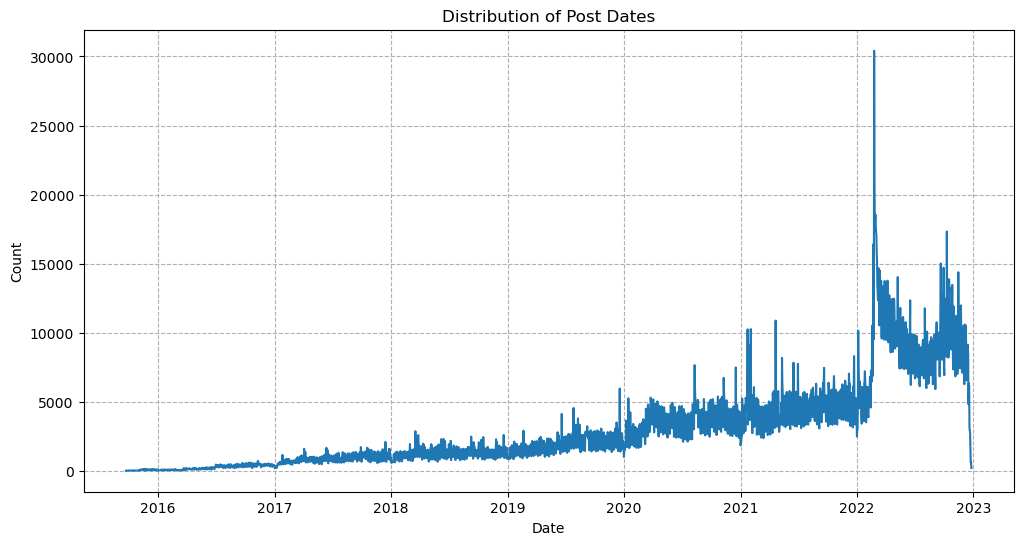

In [80]:
plt.figure(figsize=(12, 6))
post_date_distribution.plot(kind='line', rot=0)
plt.title('Distribution of Post Dates')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True, linestyle='--')
plt.savefig("graphs/DistributionOfPostDates.png")
plt.show()

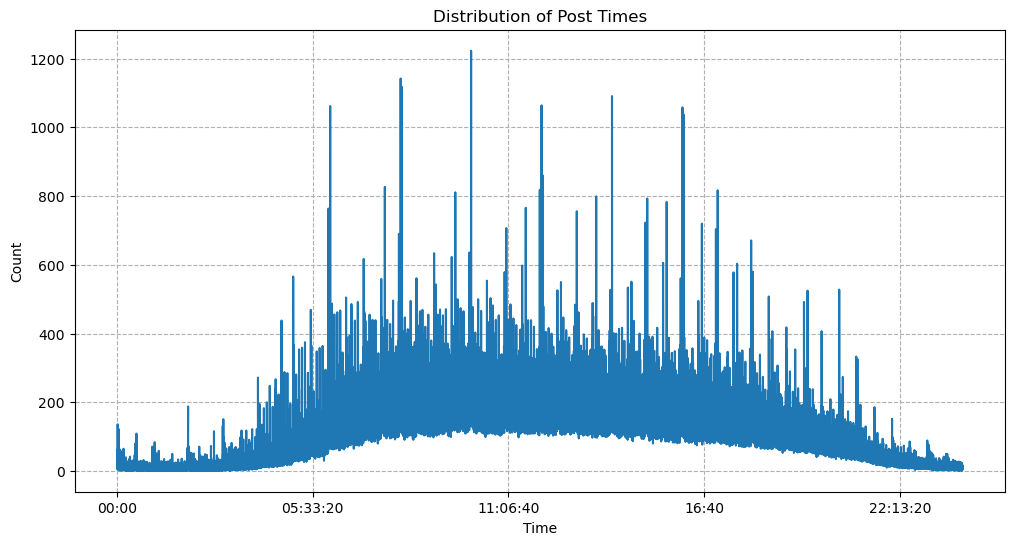

In [81]:
plt.figure(figsize=(12, 6))
post_time_distribution.plot(kind='line', rot=0)
plt.title('Distribution of Post Times')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True, linestyle='--')
plt.savefig("graphs/DistributionOfPostTimes.png")
plt.show()

## Question: What is the most common time of day for posts to be made in each channel?

In [82]:
df['date'] = pd.to_datetime(df['date'], utc=True)

df['hour'] = df['date'].dt.hour


channel_hour_counts = df.groupby(['channel_name', 'hour']).size().reset_index(name='post_count')


idx = channel_hour_counts.groupby('channel_name')['post_count'].transform(max) == channel_hour_counts['post_count']
most_common_hours = channel_hour_counts[idx]


print("Most Common Hours for Posts in Each Channel:")
print(most_common_hours)

Most Common Hours for Posts in Each Channel:
        channel_name  hour  post_count
7        ASGasparyan     8        2342
30        Abbasdjuma     9         901
57    Alekhin_Telega    14         521
74      Ateobreaking     9        5701
101         Baronova    12        1701
...              ...   ...         ...
6800         yurydud    14          15
6813  zakharprilepin     6        1127
6845      zhogaartem    17          15
6853     znachit_net     9         203
6876      zvezdanews     9       10037

[303 rows x 3 columns]


## Question: Which channels have the highest proportion of forwarded posts, and from which other channels are they mostly forwarded?

In [83]:
forwarded_posts = df[df['fwd_from'].notnull()]

total_forwarded_posts = forwarded_posts.groupby('channel_name')['to_id'].count()

total_posts = df.groupby('channel_name')['id'].count()

proportion_forwarded_posts = total_forwarded_posts / total_posts


channel_with_highest_proportion = proportion_forwarded_posts.idxmax()
highest_proportion = proportion_forwarded_posts.max()


channels_forwarded_from = forwarded_posts[forwarded_posts['channel_name'] == channel_with_highest_proportion]
channels_forwarded_from_counts = channels_forwarded_from['fwd_from'].str.extract(r'channel_id=(\d+)')[0].value_counts()


print(f"The channel with the highest proportion of forwarded posts is '{channel_with_highest_proportion}' with a proportion of {highest_proportion:.2f}.")
print(f"The channels mostly forwarding to '{channel_with_highest_proportion}' are:")
print(channels_forwarded_from_counts)


The channel with the highest proportion of forwarded posts is 'navideovidno' with a proportion of 0.98.
The channels mostly forwarding to 'navideovidno' are:
0
1223185389    3065
1070404049    2760
1394050290    1849
1036362176    1742
1069772626    1427
              ... 
1181003014       1
1154938445       1
1228262504       1
1437721680       1
1107235668       1
Name: count, Length: 1717, dtype: int64


## Question: How does the number of posts vary on different days of the week?

In [84]:
df['date'] = pd.to_datetime(df['date'], utc=True)
df['day_of_week'] = df['date'].dt.dayofweek

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

posts_by_day = df['day_of_week'].value_counts().sort_index()

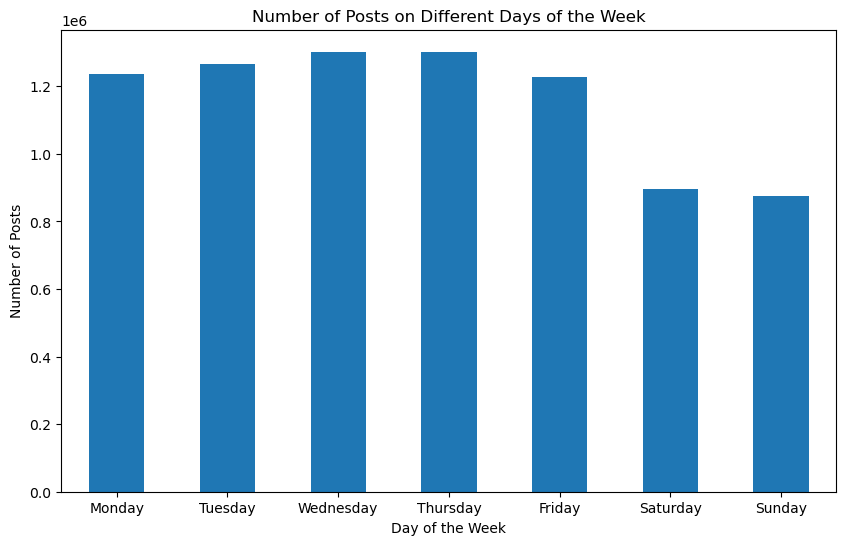

In [85]:
plt.figure(figsize=(10, 6))
posts_by_day.plot(kind='bar', rot=0)
plt.title('Number of Posts on Different Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Posts')
plt.xticks(range(7), day_names)
plt.savefig("graphs/PostsPerDayOfWeek.png")
plt.show()

## Question: Let`s make sentiment analysis of these channels

In [89]:
df['date'] = pd.to_datetime(df['date']) 

def analyze_tone(messages):
    blob = TextBlob(' '.join(str(message) for message in messages))
    return blob.sentiment.polarity

tqdm.pandas(desc="Analyzing Tone")
channel_tone_scores = df.groupby('channel_name')['message'].progress_apply(analyze_tone)

channel_tone_df = pd.DataFrame({'channel_name': channel_tone_scores.index, 'tone_score': channel_tone_scores.values})

tqdm.pandas(desc="Printing Results")
print(channel_tone_df)


Analyzing Tone: 100%|██████████| 299/299 [22:25<00:00,  4.50s/it]

       channel_name  tone_score
0       ASGasparyan    0.386917
1        Abbasdjuma    0.094276
2    Alekhin_Telega    0.128784
3      Ateobreaking    0.112373
4          Baronova    0.087408
..              ...         ...
294         yurydud   -0.231818
295  zakharprilepin    0.230145
296      zhogaartem    0.000000
297     znachit_net    0.040799
298      zvezdanews    0.065643

[299 rows x 2 columns]


In [90]:
print(channel_tone_scores.mean())

0.15030092590245597


In [91]:
sorted_channel_tone_df = channel_tone_df.sort_values(by='tone_score', ascending=False)

print("\nTop 10 Highest Sentiment Scores:")
print(sorted_channel_tone_df.head(10))

print("\nTop 10 Lowest Sentiment Scores:")
print(sorted_channel_tone_df.tail(10))


Top 10 Highest Sentiment Scores:
         channel_name  tone_score
141    maryananaumova    0.750000
13   GrafinyaNegoduet    0.600000
136        makarov_kb    0.600000
196          pgubarev    0.578125
276      vatnoeboloto    0.536659
65      bolshiepushki    0.536506
173          norin_ea    0.525463
228       rusich_army    0.487775
51           akitilop    0.470650
159        mod_russia    0.465909

Top 10 Lowest Sentiment Scores:
       channel_name  tone_score
90   glava_lnr_info    0.000000
156     mkhusnullin    0.000000
185     oper_goblin   -0.005199
258      svarschiki   -0.024004
158       mnogonazi   -0.057882
270          tvrain   -0.081818
167       naralex88   -0.180208
294         yurydud   -0.231818
160     momdontread   -0.305556
255      strelkovii   -0.518750


## Question: Let`s inspect TF-IDF analysis on the most popular channel

In [92]:
channel_name = 'medvedev_telegram'
filtered_df = df[df['channel_name'] == channel_name]

filtered_df['message'].apply(lambda x: ' '.join(str(msg) for msg in x))
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['message'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

## Top 10 TF-IDF Terms for this channel in documents:

In [93]:
num_top_terms = 10
top_terms_per_document = {}
for i, row in tfidf_df.iterrows():
    top_terms = row.sort_values(ascending=False).index[:num_top_terms]
    top_terms_per_document[i] = top_terms

for document_index, top_terms in top_terms_per_document.items():
    print(f"Document {document_index + 1}: Top {num_top_terms} TF-IDF Terms - {', '.join(top_terms)}")

Document 1: Top 10 TF-IDF Terms - противника, объекты, военных, инфраструктуре, пп, комбатанты, разному, законными, официально, целях
Document 2: Top 10 TF-IDF Terms - видимо, упоротый, просит, пушечного, критической, кровь, живого, мяса, свежая, клоун
Document 3: Top 10 TF-IDF Terms - враг, присягнувших, фамилиями, псевдоукраинские, основаны, производство, принципах, захлебываясь, родной, мест
Document 4: Top 10 TF-IDF Terms - футболе, финал, вражеских, стран, северный, сдерживания, сделать, сделали, сделал, священна
Document 5: Top 10 TF-IDF Terms - гетман, издевался, хай, устройство, пушкину, терроризировал, формирование, развёл, языком, турбин
Document 6: Top 10 TF-IDF Terms - отечества, героев, пожертвовать, тусклой, разжиревших, пример, помним, поэтому, герой, защищая
Document 7: Top 10 TF-IDF Terms - размениваясь, масс, стоило, ненужные, медиа, благодаря, отметить, компромиссы, особо, работу
Document 8: Top 10 TF-IDF Terms - заговорщики, ливерная, германии, явно, пресловутый, по